In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [3]:
df = pd.read_excel("premium_young.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857


In [4]:
df.shape

(20096, 13)

In [5]:
#Change column name to consistent naming
df.columns = df.columns.str.replace(' ','_').str.lower()
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


### Data Cleaning - Handle NA Values

In [6]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [7]:
#based on total number of 50,000, number of missing value is small
#So I will just drop the row with missing value 
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [8]:
df.duplicated().sum()
# df.drop_duplicates(inplace=True)
# df.duplicated().sum()

0

### Data Cleaning - Remove Outlier

In [9]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


age column has max of 356 which is not correct, income_lakhs also show outlier with max of 930 and for number_of_dependant min should not be negative

In [10]:
df[df.number_of_dependants<0].shape

(22, 13)

In [11]:
df['number_of_dependants'][df.number_of_dependants<0].unique()

array([-3, -1], dtype=int64)

We need to talk to Data Engineering team, business team or other team if these values are added incorrectly

In [12]:
# in this case, assuming negative value should be positive
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

In [13]:
numeric_columns = df.select_dtypes(['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

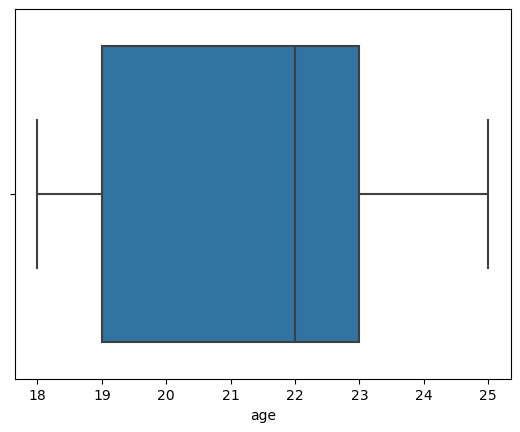

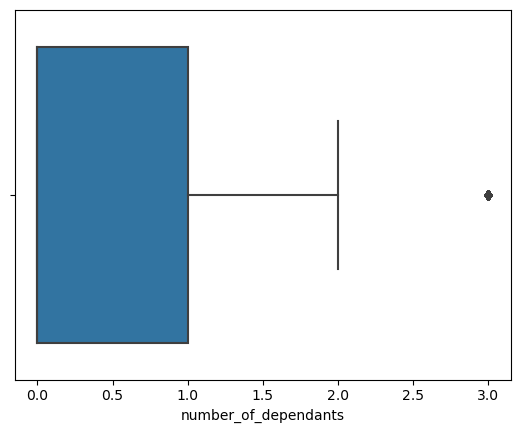

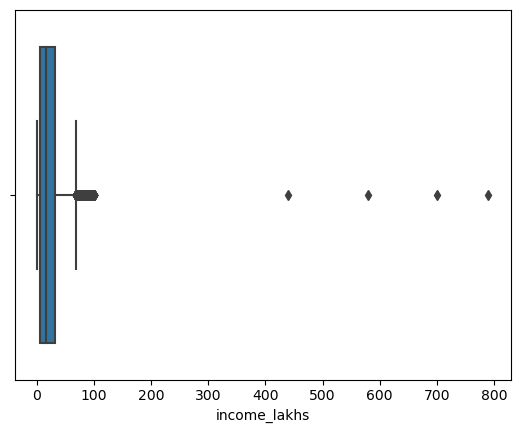

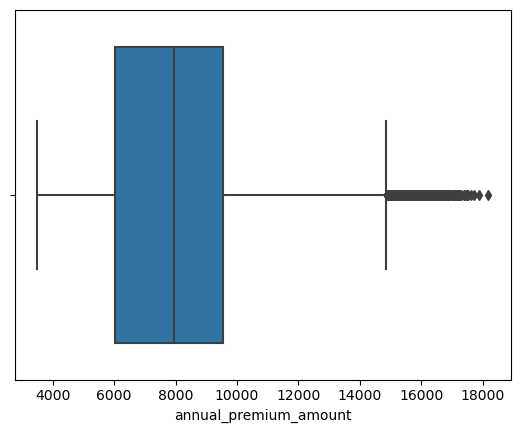

In [14]:
for col in numeric_columns:
    
    sns.boxplot(x=df[col])
    plt.show()

In [15]:
#check age
df[df.age > 100]['age'].unique()

array([], dtype=int64)

In [16]:
#Remove incorrect age of higher than 100
df1 = df[df.age <= 100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [17]:
df1.income_lakhs.quantile([0.25,0.75])

0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [18]:
#dealing with outlier in income column

def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5* IQR
    return lower_bound, upper_bound

In [19]:
get_iqr_bounds(df1.income_lakhs)

(-31.5, 68.5)

67 lakhs is not that extream, so we do not want to remove it

In [20]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

100.0

In [21]:
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

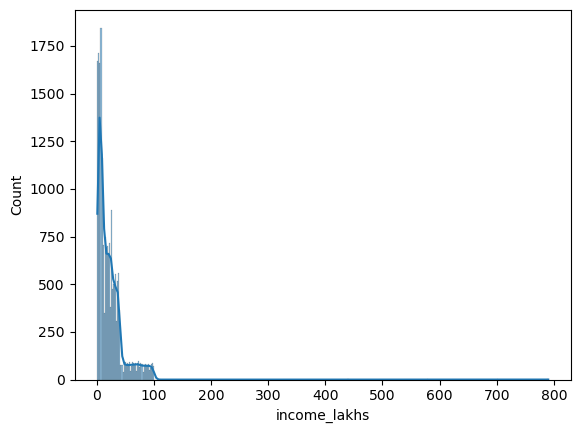

In [22]:
# with outlier
sns.histplot(df1['income_lakhs'], kde=True)

### EDA: Univariant Analysis

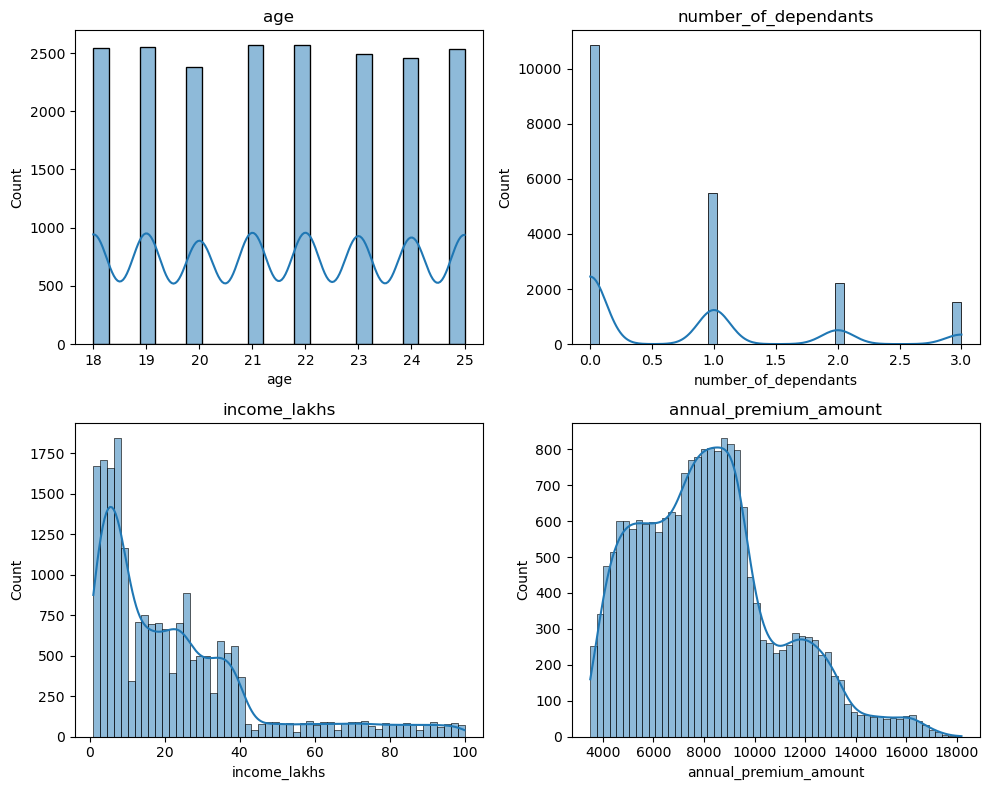

In [23]:
# without outlier
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Adjust the size as necessary

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

### EDA: Bivariant Analysis

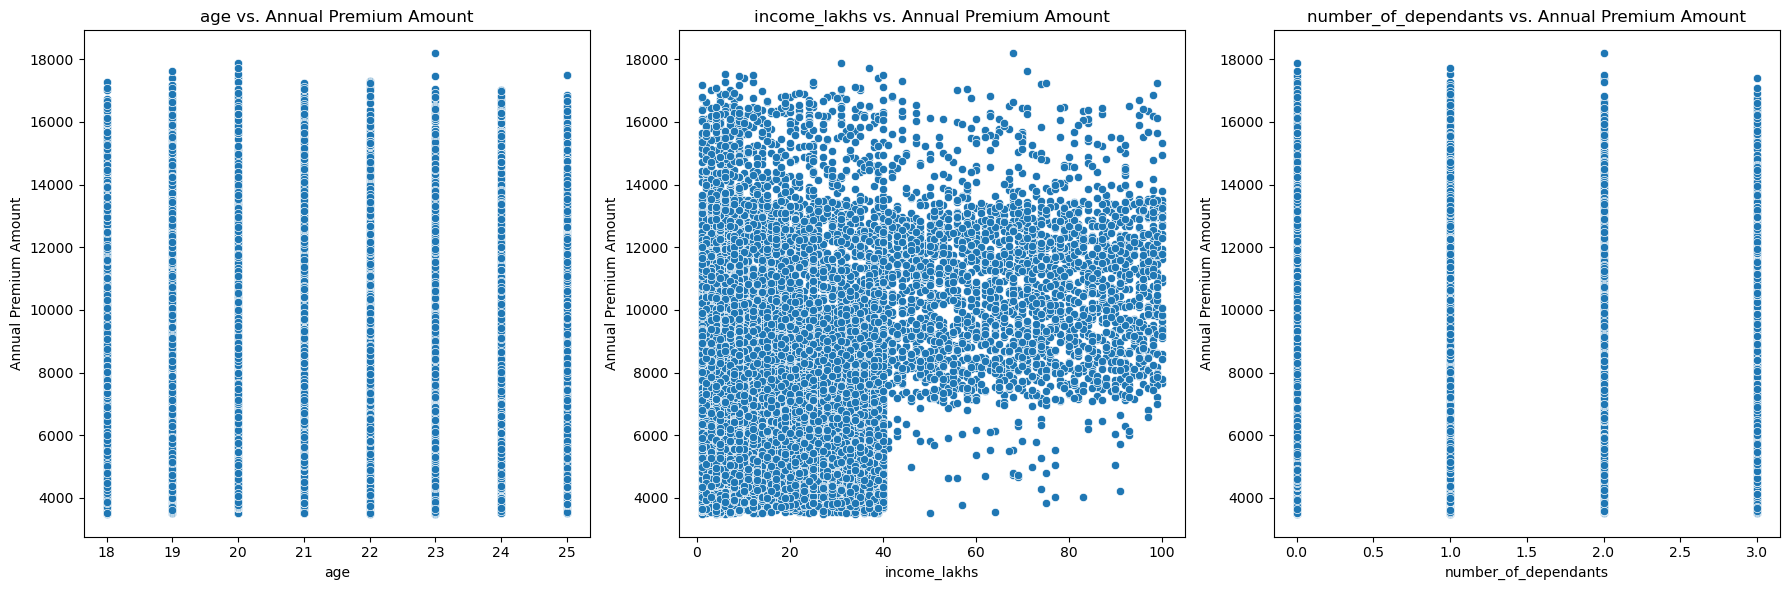

In [24]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

We can see that age increase, the annual premium is increasing, but for the other 2, we cannot see clear relationship

### EDA: Bivariate Analysis: Categorical data

In [25]:
categorical_cols = df.select_dtypes(['object']).columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [26]:
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [27]:
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking':'No Smoking'
}, inplace=True)

df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [28]:
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

<Axes: xlabel='gender'>

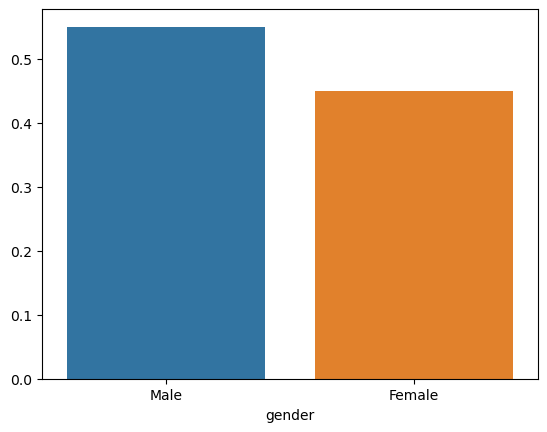

In [29]:
sns.barplot(x=pct_count.index, y=pct_count.values)

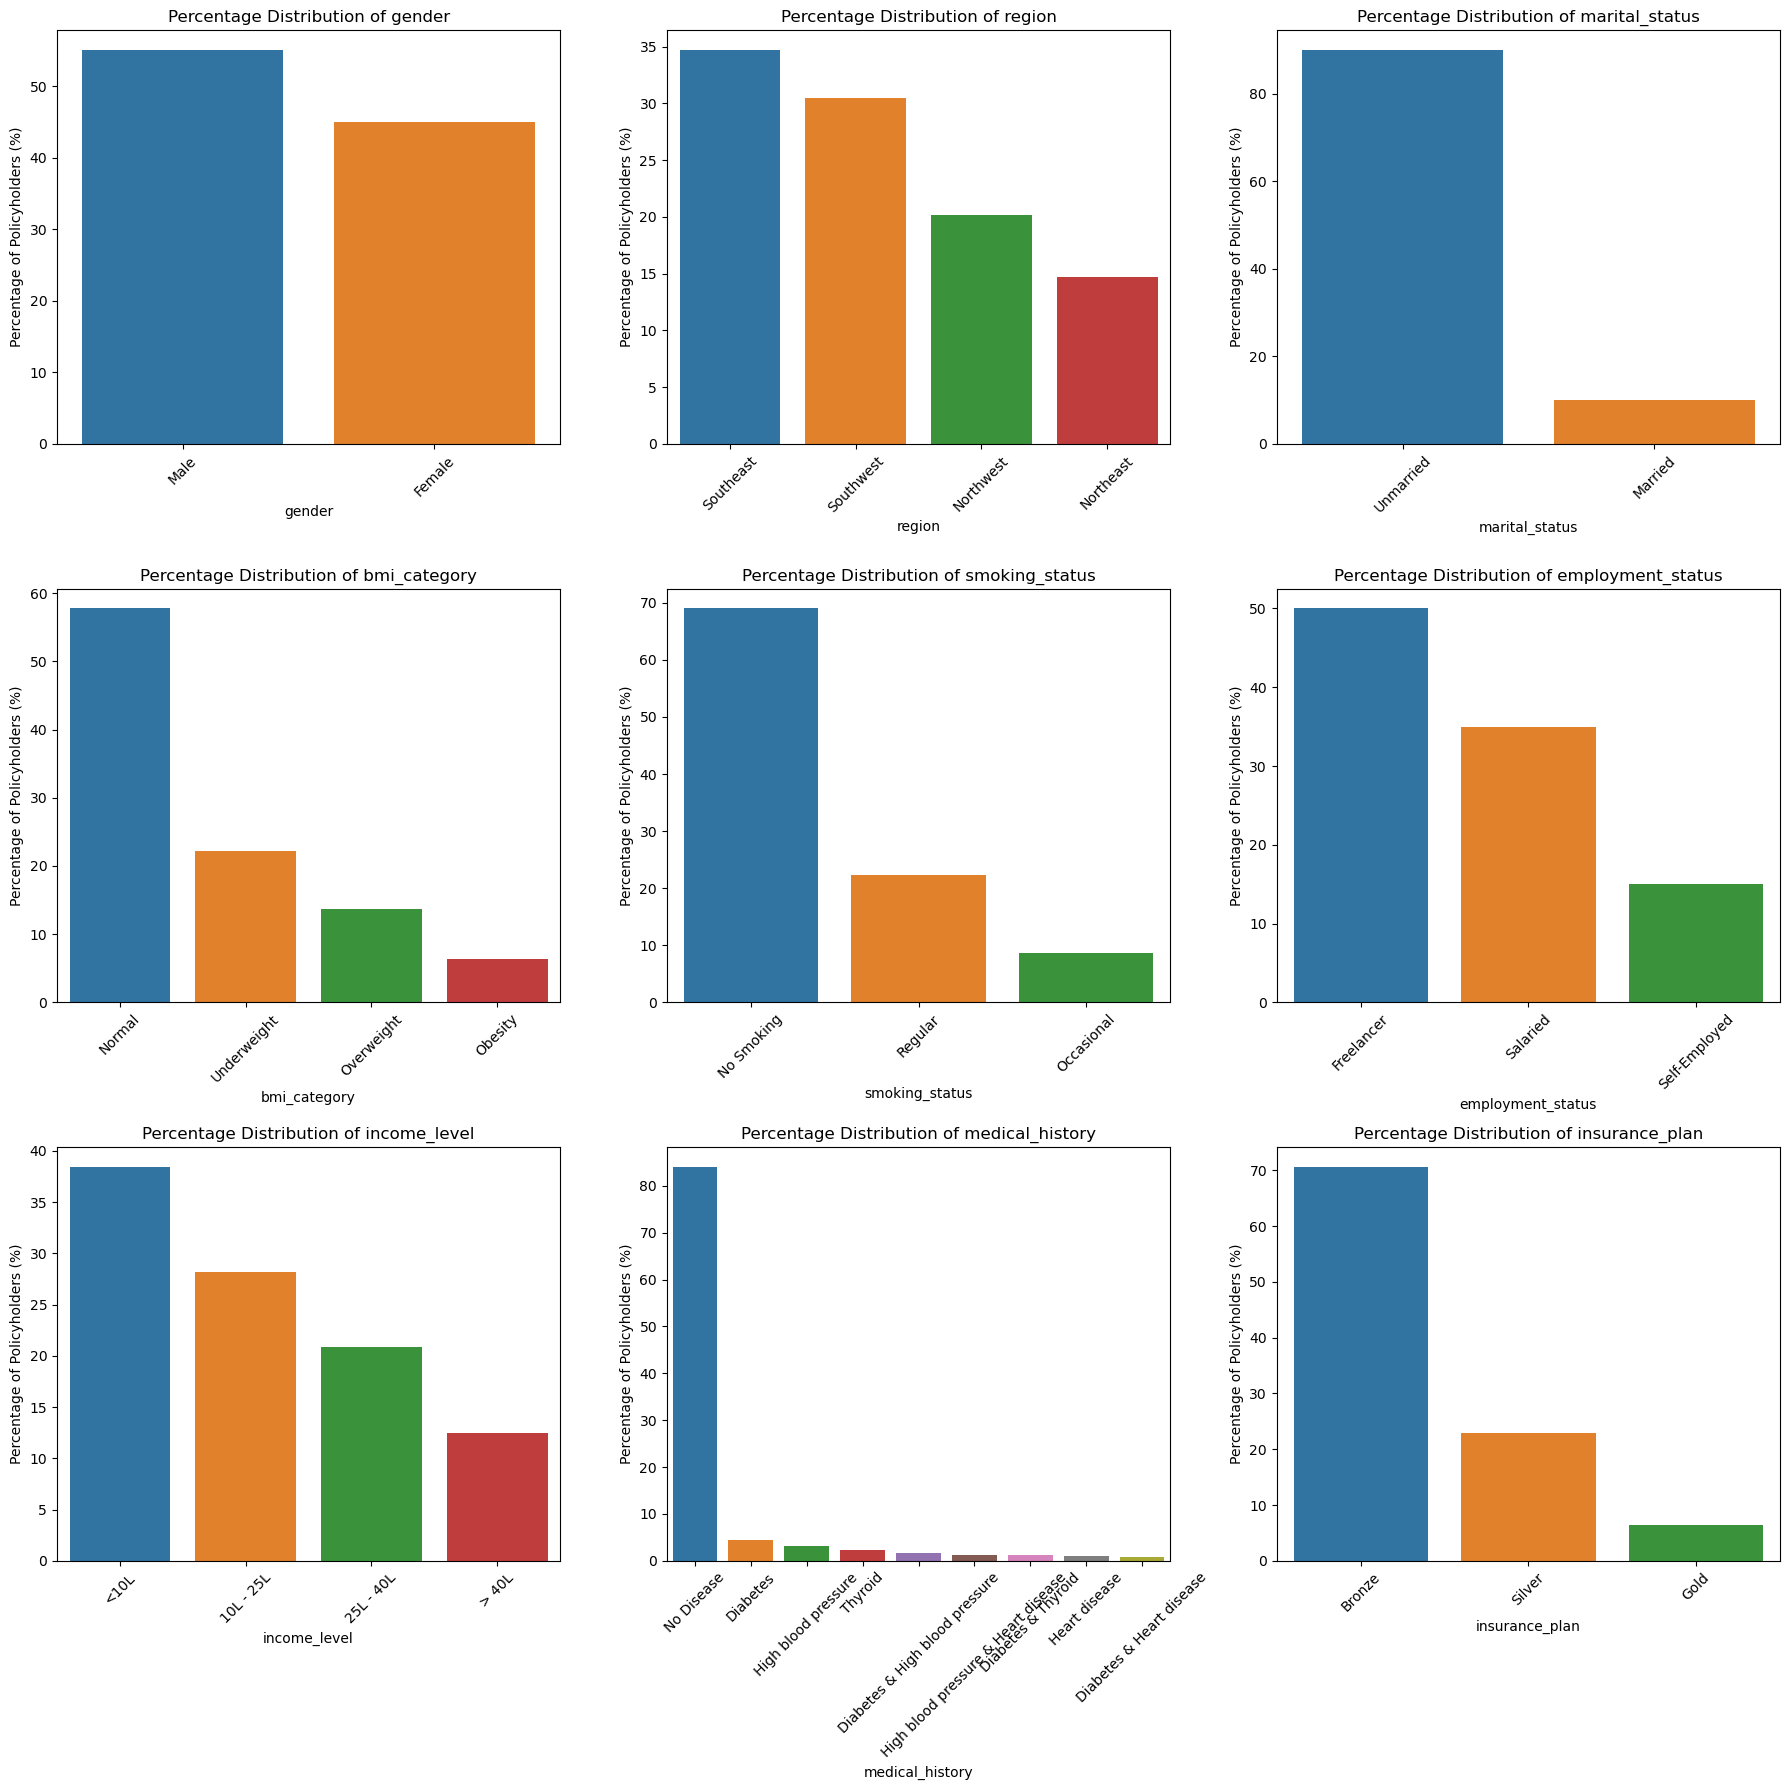

In [30]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity
    
    # Rotate the x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()


In [31]:
# income level vs insurance plane
cross_tap = pd.crosstab(df2['income_level'], df2['insurance_plan'])
cross_tap

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,4508,326,828
25L - 40L,3382,209,608
<10L,6172,404,1145
> 40L,115,366,2023


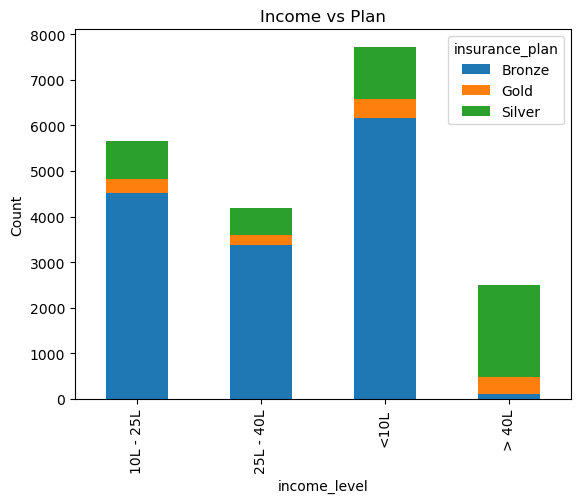

In [32]:
# Plotting the crosstab
cross_tap.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

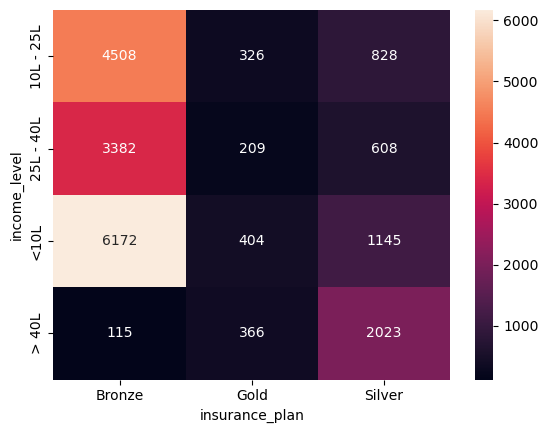

In [33]:
sns.heatmap(cross_tap, annot=True, fmt='d')
plt.show()

### Feature Engineering

In [34]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [35]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [36]:
# Define the risk scores for each condition, from business
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1','disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x:x.str.lower())
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,None


In [37]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1','disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)
    
# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000


In [38]:
df2.sample(15)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
804,18,Male,Southwest,Unmarried,1,Normal,Regular,Freelancer,10L - 25L,10,Diabetes & Heart disease,Bronze,5860,diabetes,heart disease,14,1.000000
990,21,Male,Southwest,Unmarried,1,Normal,No Smoking,Self-Employed,> 40L,67,No Disease,Silver,10244,no disease,none,0,0.000000
11413,24,Female,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,<10L,4,No Disease,Bronze,5375,no disease,none,0,0.000000
13366,23,Male,Southeast,Unmarried,1,Normal,No Smoking,Freelancer,> 40L,88,No Disease,Silver,8731,no disease,none,0,0.000000
11135,24,Female,Southwest,Unmarried,1,Normal,No Smoking,Salaried,10L - 25L,10,No Disease,Bronze,8698,no disease,none,0,0.000000
2587,24,Female,Southwest,Unmarried,0,Underweight,No Smoking,Salaried,> 40L,89,No Disease,Gold,11782,no disease,none,0,0.000000
12223,20,Male,Northwest,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,6323,no disease,none,0,0.000000
7779,19,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,25L - 40L,35,Diabetes,Bronze,6366,diabetes,none,6,0.428571
16786,22,Male,Southeast,Unmarried,1,Normal,Regular,Freelancer,25L - 40L,40,No Disease,Silver,9340,no disease,none,0,0.000000
13394,21,Female,Northeast,Unmarried,0,Normal,No Smoking,Salaried,> 40L,82,No Disease,Silver,10559,no disease,none,0,0.000000


In [39]:
df2.insurance_plan.unique() #ordinal category

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [40]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df2['insurance_plan'].unique()

array([2, 1, 3], dtype=int64)

In [41]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,no disease,none,0,0.000000


In [42]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0


#### Feature Selection

In [43]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


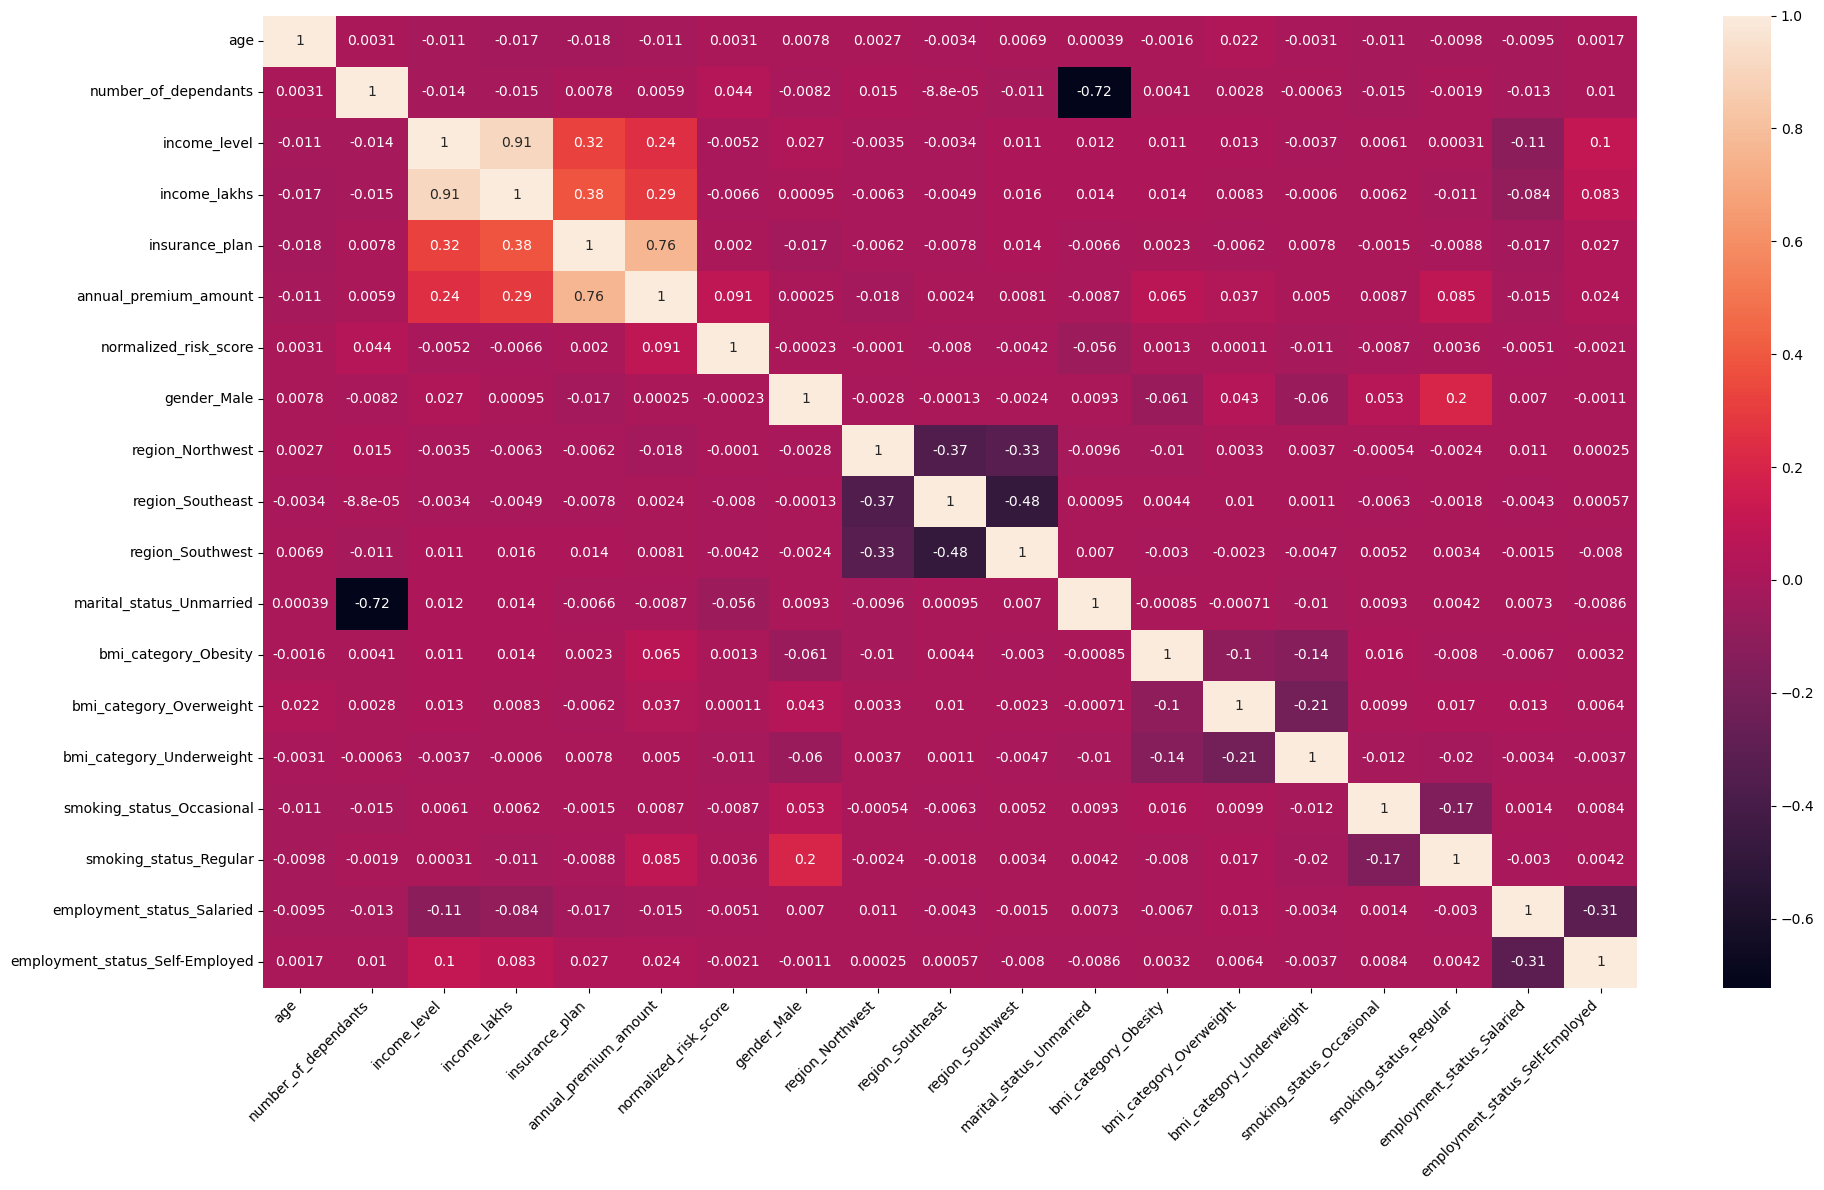

In [44]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [45]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0


It is better to calculate VIF showing relationship of one feature to other features

In [46]:
X = df4.drop('annual_premium_amount', axis=1)
y = df4['annual_premium_amount']

# scaling before VIF
from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,1.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.333333,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.333333,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


In [47]:
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
#Calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [49]:
calculate_vif(X)

,Column,VIF
0,age,3.142881
1,number_of_dependants,1.860761
2,income_level,11.928707
3,income_lakhs,11.874242
4,insurance_plan,1.592892
5,normalized_risk_score,1.154223
6,gender_Male,2.310023
7,region_Northwest,2.147701
8,region_Southeast,2.970188
9,region_Southwest,2.730503


From correlation metric, income_level and income_lakhs has high correlation, which we will normally drop 1 from it

In [50]:
#drop column with highest VIF between income_level and income lakhs

calculate_vif(X.drop('income_level', axis=1))

,Column,VIF
0,age,3.141534
1,number_of_dependants,1.858110
2,income_lakhs,2.291873
3,insurance_plan,1.587794
4,normalized_risk_score,1.154174
5,gender_Male,2.299848
6,region_Northwest,2.146767
7,region_Southeast,2.968993
8,region_Southwest,2.729813
9,marital_status_Unmarried,7.299818


**Good Practice to drop feature one by one and see**

In [51]:
X_reduced = X.drop('income_level', axis=1)
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


### Model Training

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (14060, 17)
x test:  (6026, 17)
y train:  (14060,)
y test:  (6026,)


#### Model Training: Linear Regression

In [53]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

(0.6020471274164894, 0.6047589163893645)

In [54]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  3005669.8791236714 RMSE:  1733.6867880686152


In [55]:
X_test.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12774,1.000000,0.666667,0.040404,0.0,0.0,1,0,0,1,1,0,0,1,0,0,0,0
14758,0.285714,0.000000,0.060606,0.0,0.0,0,0,0,1,1,0,0,0,0,1,0,1
13205,0.714286,0.333333,0.141414,0.0,0.0,1,1,0,0,1,0,0,0,0,1,0,1
14278,0.714286,0.333333,0.222222,0.0,0.0,1,0,1,0,1,1,0,0,0,1,0,0
19351,0.571429,0.000000,0.101010,0.0,0.0,1,0,0,1,1,0,0,1,0,0,0,0


In [56]:
model_lr.intercept_

6614.5833912307535

In [57]:
model_lr.coef_

array([ 5.51905147e+01, -1.45039643e+02, -3.60667677e+01,  7.00007042e+03,
        1.11127879e+03,  9.82564766e+00, -1.14273450e+02, -3.64663714e+01,
       -6.72232248e+01, -5.85343424e+01,  7.92952660e+02,  4.35760406e+02,
        1.69728916e+02,  2.44813937e+02,  6.19082947e+02, -1.30535485e+01,
       -4.34272200e+00])

In [58]:

feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, columns=["Coefficients"], index=X_test.columns)
coef_df = coef_df.sort_values(by="Coefficients", ascending=True)
coef_df

,Coefficients
number_of_dependants,-145.039643
region_Northwest,-114.273450
region_Southwest,-67.223225
marital_status_Unmarried,-58.534342
region_Southeast,-36.466371
income_lakhs,-36.066768
employment_status_Salaried,-13.053549
employment_status_Self-Employed,-4.342722
gender_Male,9.825648
age,55.190515


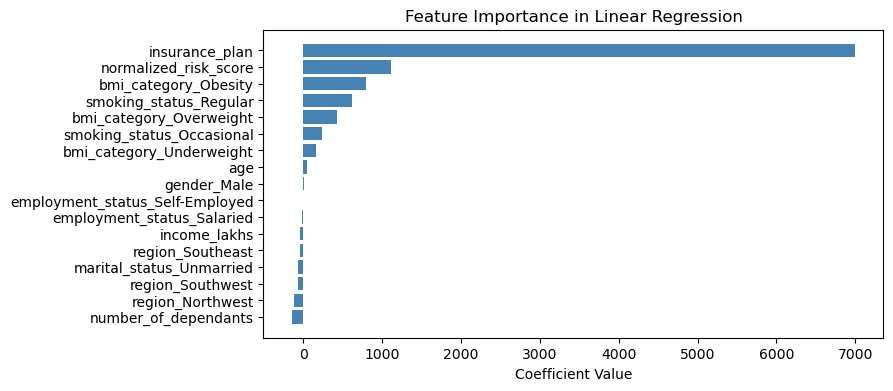

In [59]:
# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

#### Model Training: Ridge

In [60]:
model_rg = Ridge(alpha=10)
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score

(0.6020016973203524, 0.6048405530676814)

#### Model Training: XGBoost

In [61]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.7251046895980835, 0.5638787746429443)

In [62]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression ==> MSE: ", mse_xgb, "RMSE: ", rmse_xgb)

XGBoost Regression ==> MSE:  3316548.97851731 RMSE:  1821.1394725603282


#### GridSerchCV

In [63]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.5997088948885599

The accuracy above is r^2

In [64]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

**From above model training, seem like all models provide low accuracy of 60%, so we will just use linear model as best model**

In [84]:
best_model = model_lr

In [85]:
# feature_importances = best_model.feature_importances_

# coef_df = pd.DataFrame(feature_importances, columns=["Coefficients"], index=X_test.columns)
# coef_df = coef_df.sort_values(by="Coefficients", ascending=True)
# coef_df

# plt.figure(figsize=(8, 4))
# plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
# plt.xlabel('Coefficient Value')
# plt.title('Feature Importance in XGBoost')
# plt.show()

### Error Analysis

In [86]:
y_pred = best_model.predict(X_test)

residuals =  y_pred - y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6625.420564,387.420564,6.210653
14758,9462,7117.148903,-2344.851097,-24.781770
13205,5152,7052.316369,1900.316369,36.885023
14278,6988,7924.504344,936.504344,13.401608
19351,4917,6696.274716,1779.274716,36.186185


<Axes: xlabel='diff_pct', ylabel='Count'>

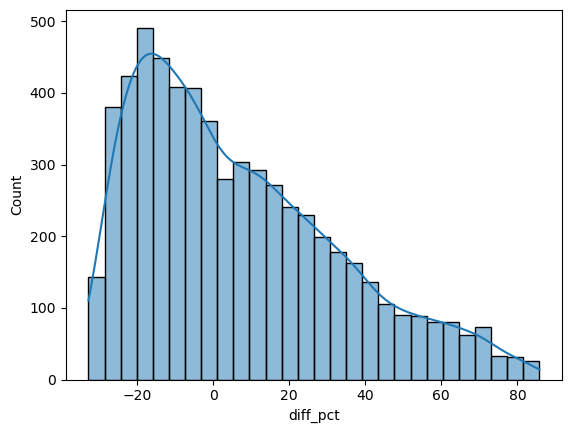

In [87]:
sns.histplot(results_df['diff_pct'], kde=True)

There are many point that have very high error, so we need to decide the treshold. The error should not exceed 10%

In [88]:
extreme_error_threshold = 10 
extreme_result_df = results_df[np.abs(results_df.diff_pct) > extreme_error_threshold]
extreme_result_df.shape

(4404, 4)

In [89]:
results_df.shape

(6026, 4)

In [90]:
extreme_error_pct = extreme_result_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

73.08330567540658

In [91]:
results_df[np.abs(results_df.diff_pct) > 50].sort_values(by = 'diff_pct', ascending=False)

,actual,predicted,diff,diff_pct
10288,3623,6730.355627,3107.355627,85.767475
16580,3538,6566.644257,3028.644257,85.603286
3652,3536,6560.929382,3024.929382,85.546645
17084,3562,6608.314334,3046.314334,85.522581
18629,3616,6684.432249,3068.432249,84.857087
...,...,...,...,...
1597,4653,6988.954171,2335.954171,50.203184
12185,4440,6666.968404,2226.968404,50.156946
15966,4709,7070.742860,2361.742860,50.153809
4086,4592,6890.471576,2298.471576,50.053824


So from above, we cannot deploy models because there are many prediction with high margin error. 

In [92]:
X_test.index

Index([12774, 14758, 13205, 14278, 19351, 10622, 16391, 14799, 17184, 16348,
       ...
        8695,  9658, 14195,  1365,   399, 17652,  5807, 10298, 13316,  2583],
      dtype='int64', length=6026)

In [93]:
extreme_result_df.index

Index([14758, 13205, 14278, 19351, 10622, 14799, 16348,  5573,  5634, 14882,
       ...
       10266,  5484,  8988,  9658,  1365,   399, 17652,  5807, 10298, 13316],
      dtype='int64', length=4404)

In [94]:
#We want to get actual feture
extreme_error_df =  X_test.loc[extreme_result_df.index]
extreme_error_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14758,0.285714,0.000000,0.060606,0.0,0.000000,0,0,0,1,1,0,0,0,0,1,0,1
13205,0.714286,0.333333,0.141414,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,1
14278,0.714286,0.333333,0.222222,0.0,0.000000,1,0,1,0,1,1,0,0,0,1,0,0
19351,0.571429,0.000000,0.101010,0.0,0.000000,1,0,0,1,1,0,0,1,0,0,0,0
10622,0.428571,0.333333,0.050505,0.0,0.357143,0,0,1,0,1,0,1,0,0,0,0,0


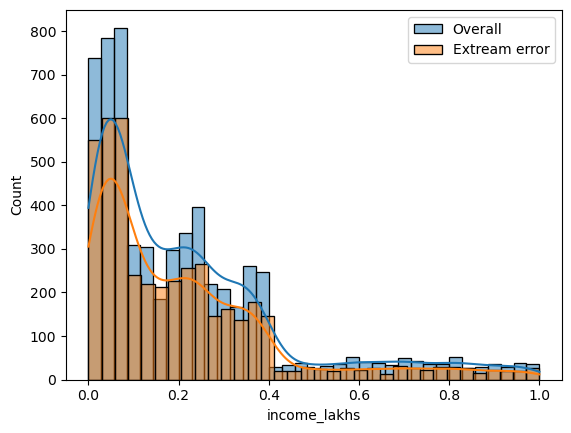

In [95]:
sns.histplot(X_test.income_lakhs, kde=True, label="Overall")
sns.histplot(extreme_error_df.income_lakhs, kde=True, label="Extream error")
plt.legend()
plt.show()

The overall income in orginal X_test data and the extreme error are similar in distribution, so the error are spread across all the income group in similar fasion

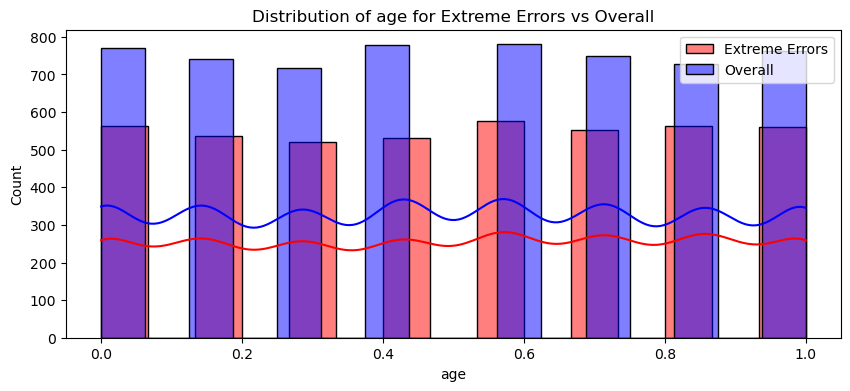

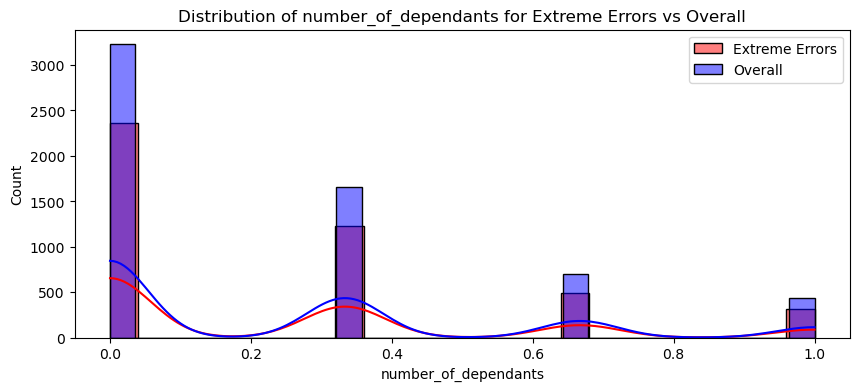

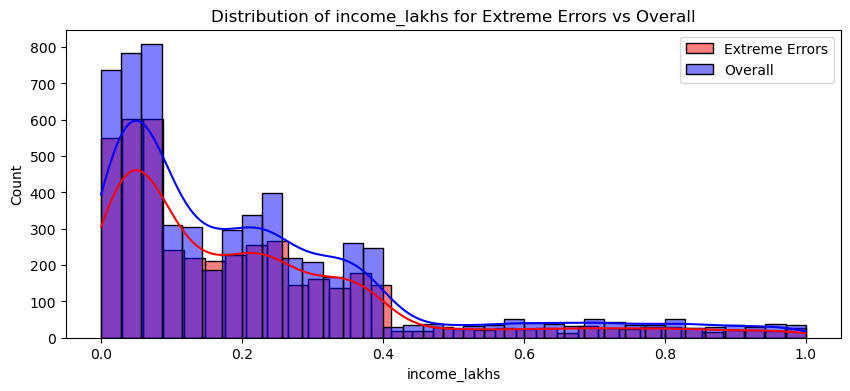

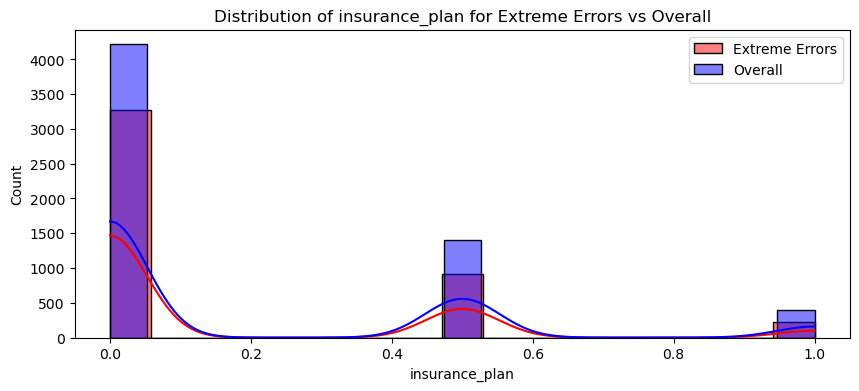

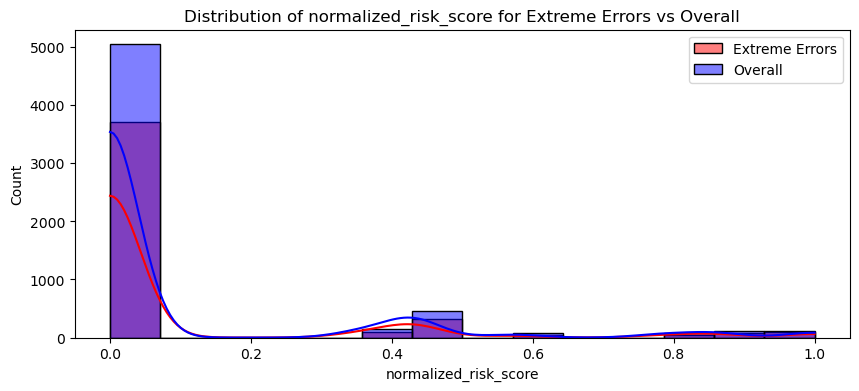

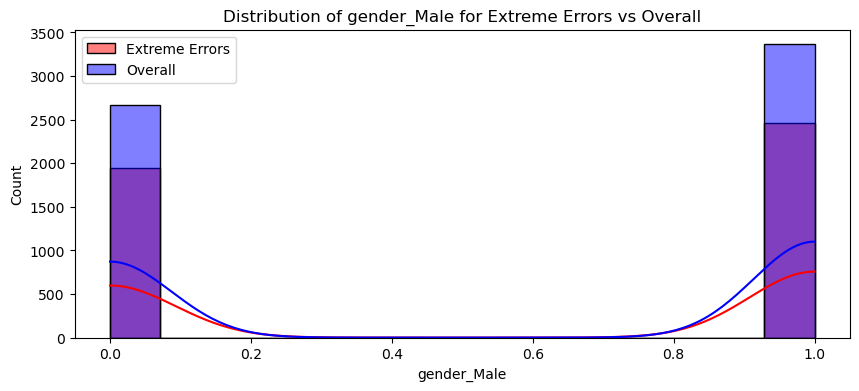

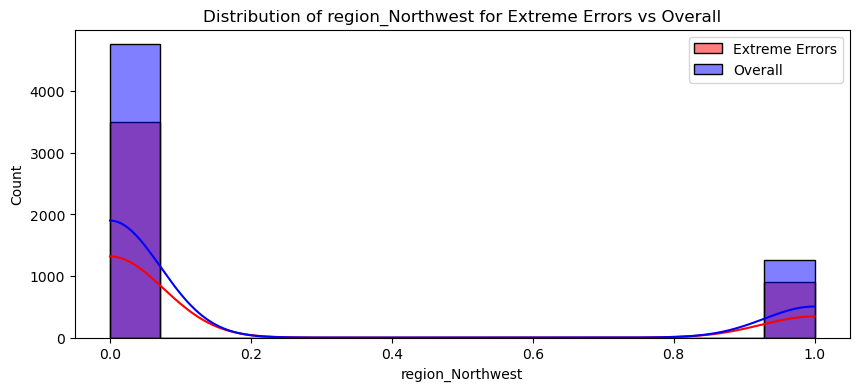

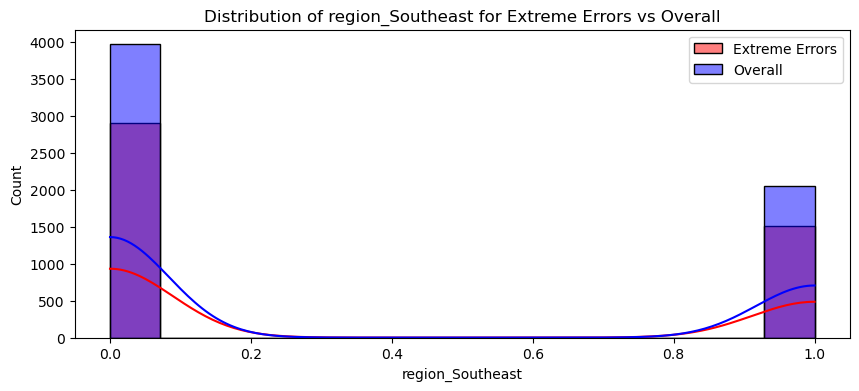

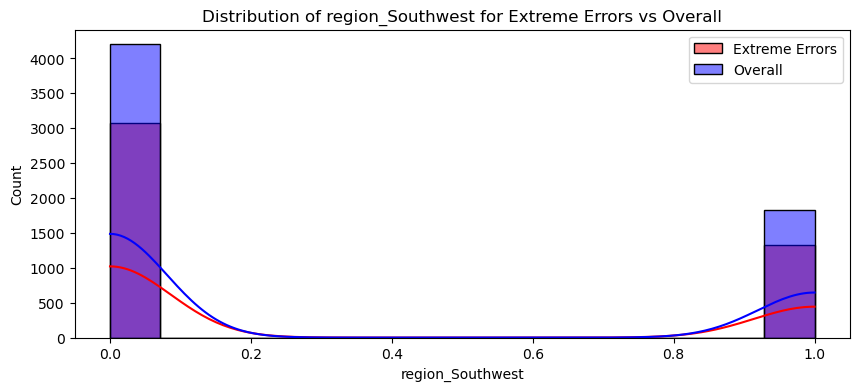

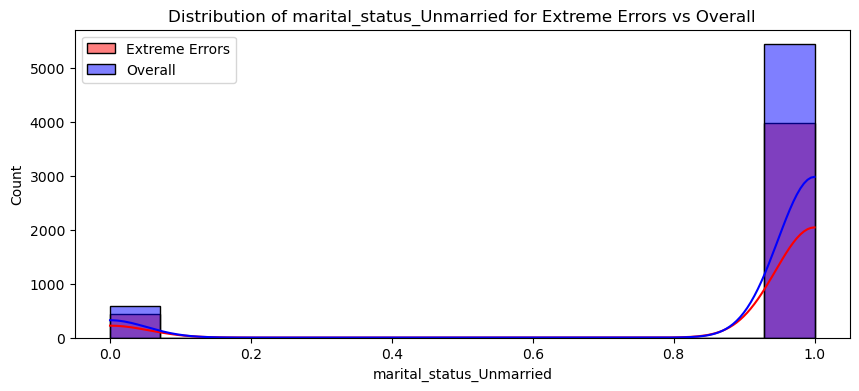

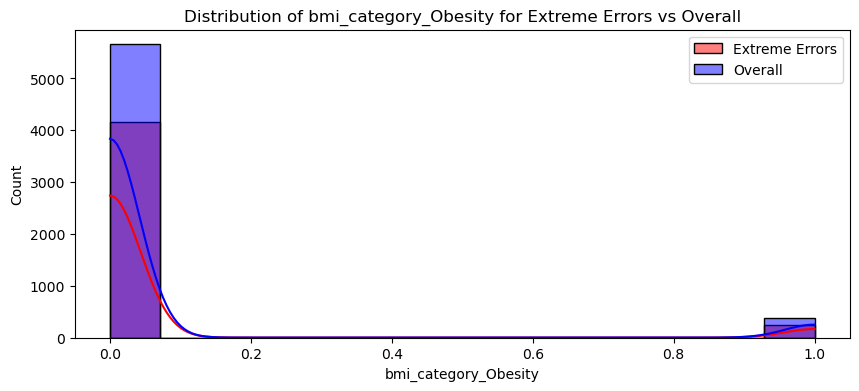

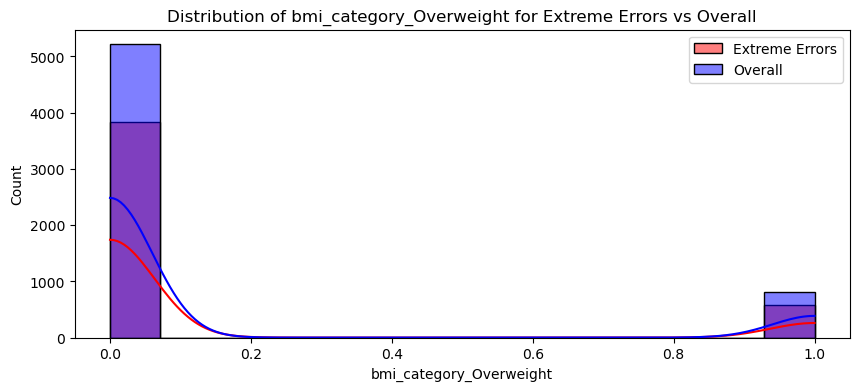

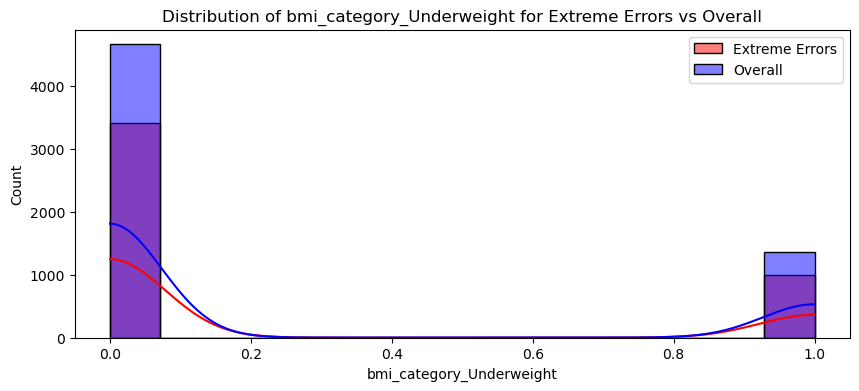

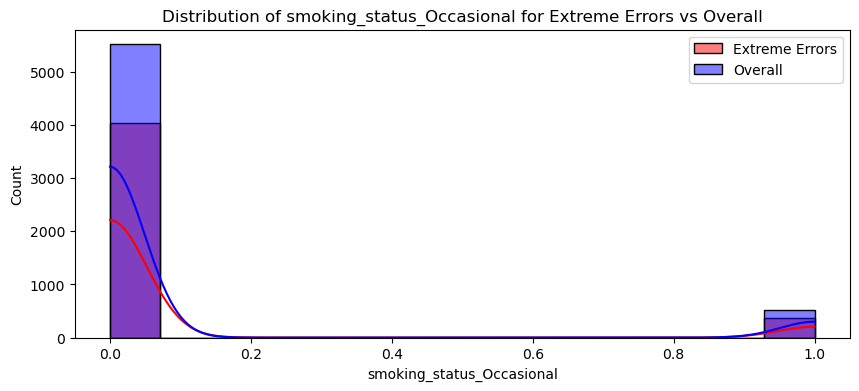

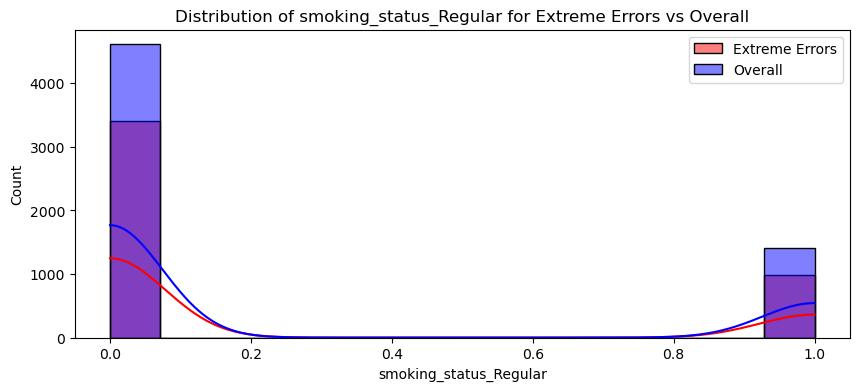

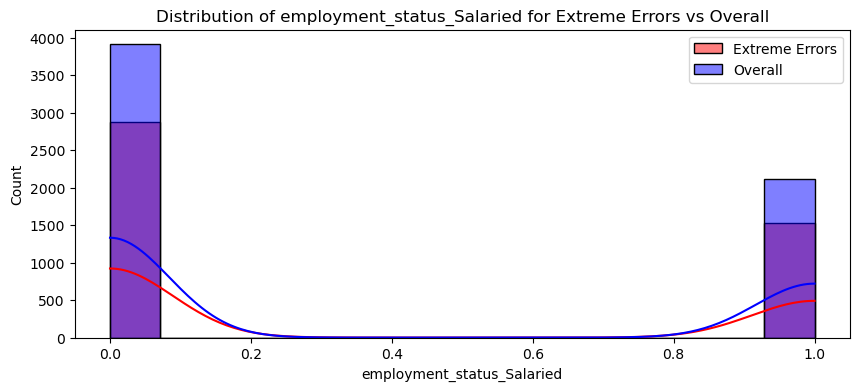

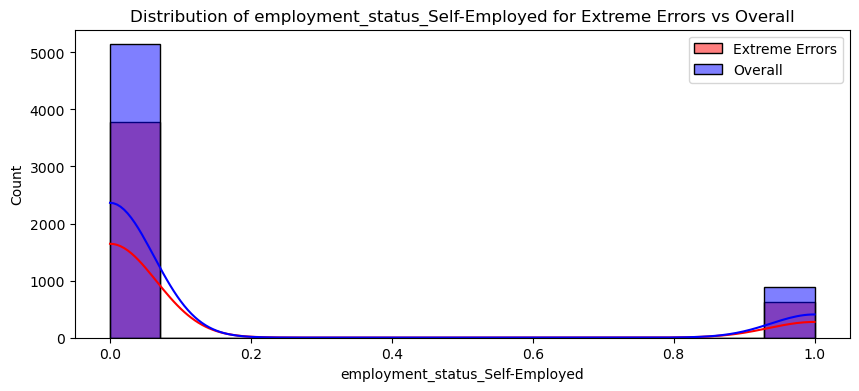

In [96]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_error_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

The shape of error and original data of other are similar. so we did not see a clear pattern of error in this dataset

**Maybe we can get more data or try different feature engineering technique**

In [78]:
extreme_error_df.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [79]:
extreme_error_df['income_level'] = -1

In [80]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_error_df[cols_to_scale])
df_reversed

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,20.0,0.0,-2.0,7.0,1.0
1,23.0,1.0,-2.0,15.0,1.0
2,23.0,1.0,-2.0,23.0,1.0
3,22.0,0.0,-2.0,11.0,1.0
4,21.0,1.0,-2.0,6.0,1.0
...,...,...,...,...,...
4402,19.0,2.0,-2.0,12.0,1.0
4403,22.0,0.0,-2.0,35.0,1.0
4404,24.0,1.0,-2.0,5.0,1.0
4405,18.0,0.0,-2.0,12.0,2.0


<Axes: xlabel='age', ylabel='Count'>

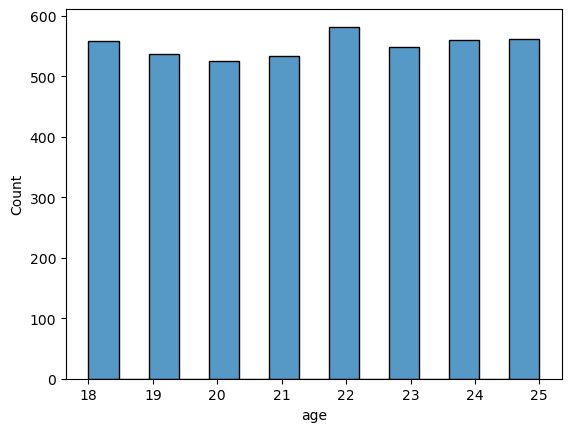

In [81]:
sns.histplot(df_reversed['age'])

In [82]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4407.000000,4407.000000,4407.0,4407.000000,4407.000000
mean,21.529158,0.719083,-2.0,21.531881,1.313592
std,2.298631,0.925042,0.0,20.973262,0.565424
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,20.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,30.000000,2.000000
max,25.000000,3.000000,-2.0,100.000000,3.000000


In [83]:
df_reversed['age'].quantile(0.97)

25.0

97% of your record are age 25 or less, so it mean that 97% of extream error record have age 25 or less